### Demo: Using Linearized Optimal Transport to Find Wasserstein Barycenters

Using tools from: https://github.com/srjr-hkannan/LOTpython
Reference for framework: https://arxiv.org/abs/2201.10590

Creating a demo guassian, sheared version, and candidate for LOT reference

In [429]:
#Import required packages
import numpy as np
import matplotlib.pyplot as plt
import ot
import ot.plot
import sys
import math
import os
import seaborn as sns
import Gaussians

In [430]:
#Sample m points from reference distribution - multivariate Gaussian distribution
n = 50
m = 2500
sigma = 1e-1

#Mean and covariance for template distribution
mu = np.array([1, 1]) # Center of the grid
cov = pow(sigma,2)*np.identity(2) # Independent in x,y

x = np.linspace(-2,2 - 1/n,n) #Grid step values on x-axis
y = np.linspace(-2,2 - 1/n,n) #Grid step values on y-axis

unsheared_samples, template = Gaussians.DiscreteGaussian(mu,cov,x,y,n,m)

#Mean and covariance for template distribution to be sheared
mu = np.array([0, 0])
cov = pow(sigma,2)*np.identity(2)

#Mean and covariance for sheared distribution
theta = np.radians(45)
lambda_1 = 0.1
lambda_2 = 0.2
b = -1*np.ones(2)

# Create the shearing matrix
P = np.asarray([[np.cos(theta), -np.sin(theta)],[np.sin(theta), np.cos(theta)]])
Lambda = np.diag([lambda_1, lambda_2])
A = np.matmul(np.transpose(P), np.matmul(Lambda,P))

# Shear the mean and covariance matrices
sheared_mu = np.matmul(A,mu) + b
sheared_cov = np.matmul(A,np.transpose(A))
sheared_samples, sheared_template = Gaussians.DiscreteGaussian(sheared_mu,sheared_cov,x,y,n,m)

#Mean and covariance for reference distribution
lambda_1 = .1
lambda_2 = .2
d = 0*np.ones(2)
Lambda = np.diag([lambda_1, lambda_2])
C = np.matmul(np.transpose(P), np.matmul(Lambda,P))
reference_mu = np.matmul(C,mu) + d
reference_cov = np.matmul(C,np.transpose(C))
reference_samples, reference = Gaussians.DiscreteGaussian(reference_mu,reference_cov, x,y,n,m)

# Some values
print(mu)
print(sheared_mu)
print(reference_mu)

[0 0]
[-1. -1.]
[0. 0.]


Visualizing the Demo distributions- original, sheared, and candidate for LOT reference

[Text(0.5, 1.0, 'Reference samples snapped to a 28 x 28 grid')]

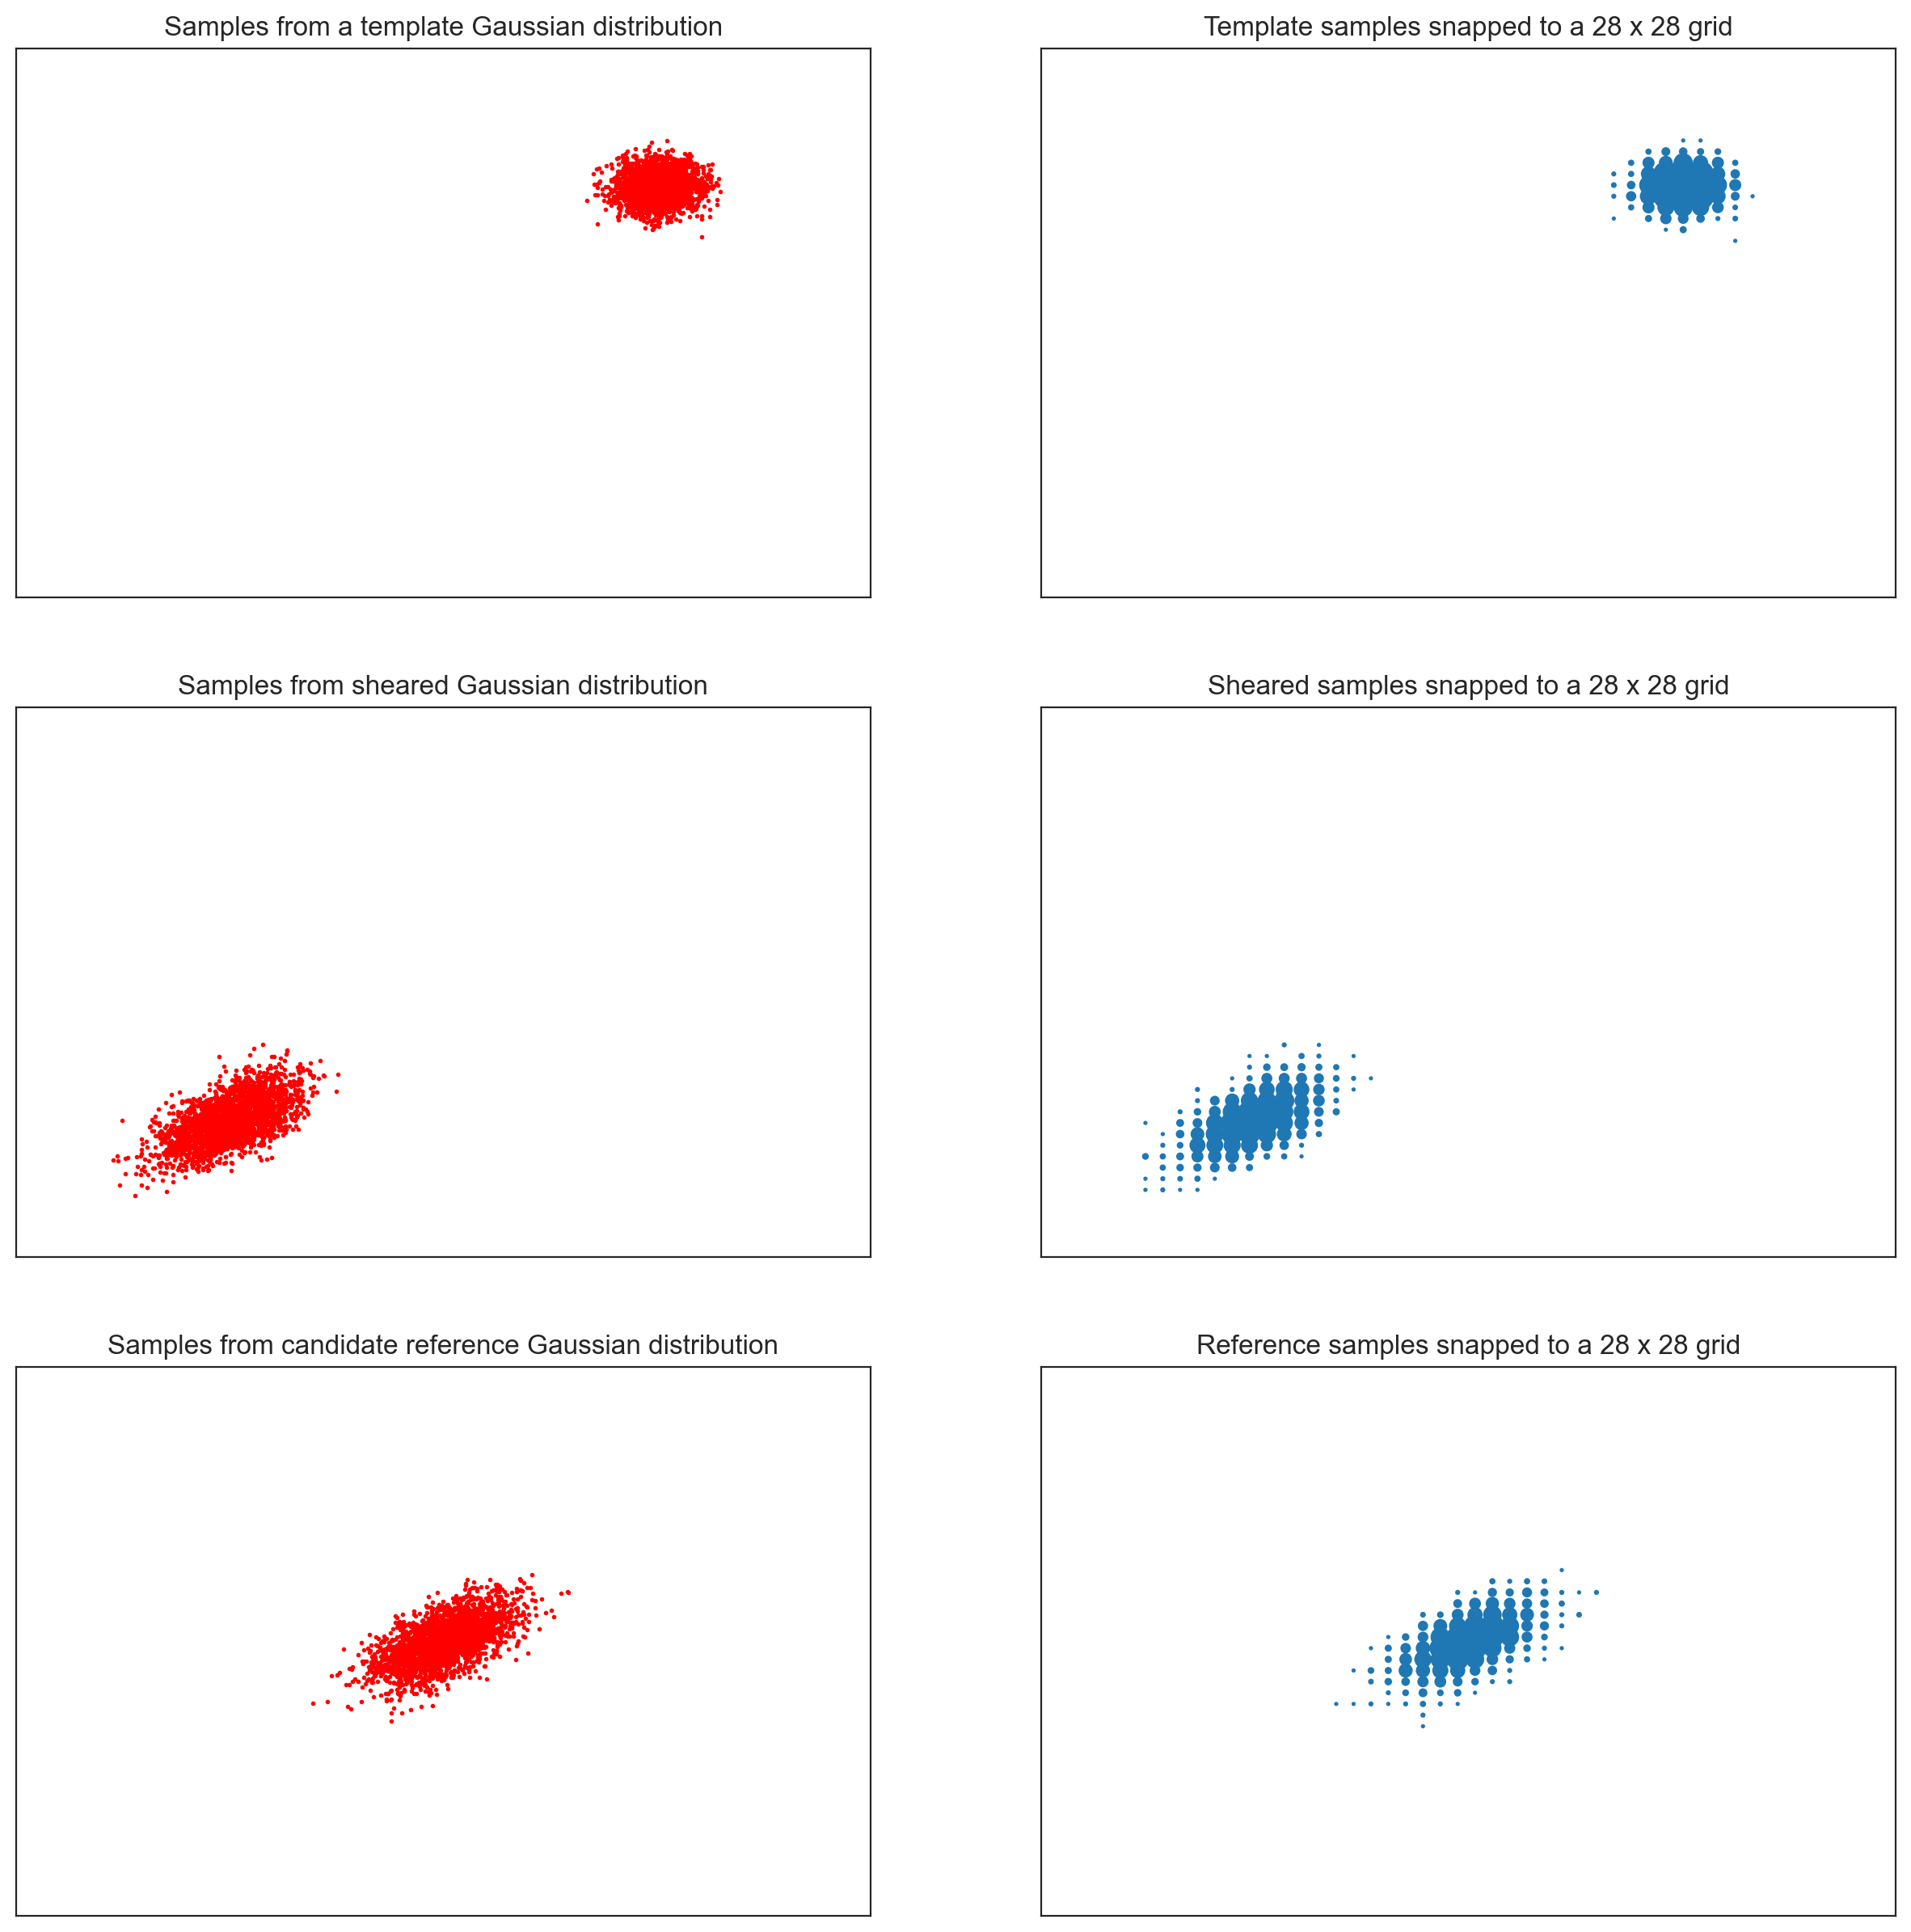

In [431]:
#Design stuff
sns.set_style("white")
plt.rcParams["figure.figsize"] = (15,15)
plt.rcParams["figure.dpi"] = 200

#Plot Grid with the template samples
fig, ax = plt.subplots(3,2)
num_gridPoints = np.linspace(-2,2 - 1/n,n)
grid_points=[]
for i in range(0,n):
    for j in range(0,n):
        grid_points.append([x[i], y[j]])

grid_points = np.asarray(grid_points)

for i in range(0,3):
    for j in range(0,2):
        ax[i,j].set_xlim([-2, 2])
        ax[i,j].set_ylim([-2, 2])
        ax[i,j].set_xticks(num_gridPoints)
        ax[i,j].set_yticks(num_gridPoints)
        ax[i,j].xaxis.grid(False)
        ax[i,j].yaxis.grid(False)
        ax[i,j].tick_params(labelbottom=False)
        ax[i,j].tick_params(labelleft=False)


ax[0,0].plot(unsheared_samples[:, 0], unsheared_samples[:, 1], 'or',markersize=1)
ax[0,0].set_title('Samples from a template Gaussian distribution')

ax[0,1].scatter(grid_points[:,0],grid_points[:,1],s=2e3*template)
ax[0,1].set(title="Template samples snapped to a 28 x 28 grid")

ax[1,0].plot(sheared_samples[:, 0], sheared_samples[:, 1], 'or',markersize=1)
ax[1,0].set_title('Samples from sheared Gaussian distribution')

ax[1,1].scatter(grid_points[:,0],grid_points[:,1],s=2e3*sheared_template)
ax[1,1].set(title="Sheared samples snapped to a 28 x 28 grid")

ax[2,0].plot(reference_samples[:, 0], reference_samples[:, 1], 'or',markersize=1)
ax[2,0].set_title('Samples from candidate reference Gaussian distribution')

ax[2,1].scatter(grid_points[:,0],grid_points[:,1],s=2e3*reference)
ax[2,1].set(title="Reference samples snapped to a 28 x 28 grid")

#fig.savefig("Images/TestGaussians.png",bbox_inches="tight",dpi=500)

Find OT & LOT Barycenters of original and sheared distributions

In [432]:
# Squared Euclidean Cost matrix between the grid points
Cost = ot.dist(grid_points, grid_points, metric = "sqeuclidean")

# Finding the sinkhorn barycenter of the two distributions using POT native tools
sinkhornBarycenter = ot.bregman.barycenter(np.asarray([template, sheared_template]).T, Cost, 2.5e-2, weights=[0.5, 0.5])

# Since we know that the Monge map will be a shear, estimate the Monge map in both cases:
A, b = ot.da.OT_mapping_linear(unsheared_samples, sheared_samples)

A1_hat, b1_hat = ot.da.OT_mapping_linear(reference_samples, unsheared_samples)
A2_hat, b2_hat = ot.da.OT_mapping_linear(reference_samples, sheared_samples)

# These are the LOT embeddings, so average them in L2 space.
A_mid, b_mid = (A1_hat + A2_hat) / 2, (b1_hat + b2_hat) / 2

# Now calculate the pushforward of the 1st template via the L2 midpoint map
mu = np.matmul(A_mid, reference_mu) + b_mid
cov = np.matmul(A_mid, np.matmul(reference_cov, np.transpose(A_mid)))

pushforward_samples, pushforward_template = Gaussians.DiscreteGaussian(mu,cov,x,y,n,m)


Visualizing the Sinkhorn Barycenter

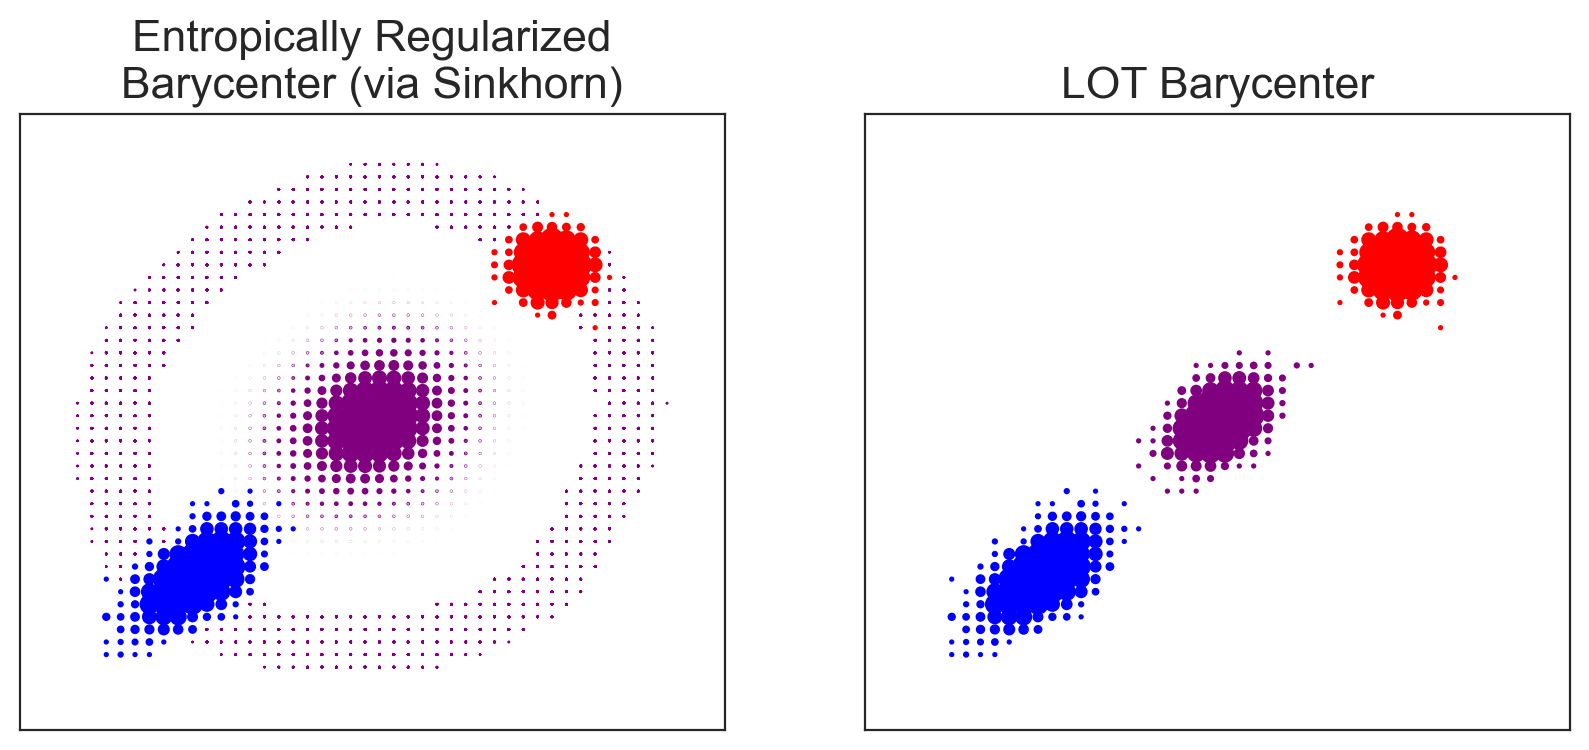

In [433]:
#Design stuff
sns.set_style("white")
plt.rcParams["figure.figsize"] = (10,4)
plt.rcParams["figure.dpi"] = 200

titleDict = {'fontsize': 16}

#Plot Grid with the template samples
fig, ax = plt.subplots(1,2)

for i in range(0, 2):
    ax[i].set_xlim([-1.5, 1.5])
    ax[i].set_ylim([-1.5, 1.5])
    ax[i].set_xticks(num_gridPoints)
    ax[i].set_yticks(num_gridPoints)
    ax[i].xaxis.grid(False)
    ax[i].yaxis.grid(False)
    ax[i].tick_params(labelbottom=False)
    ax[i].tick_params(labelleft=False)

ax[0].set_title('Entropically Regularized\nBarycenter (via Sinkhorn)', titleDict)
ax[0].scatter(grid_points[:,0],grid_points[:,1], s=2e3 * sinkhornBarycenter, c='purple')
ax[0].scatter(grid_points[:,0],grid_points[:,1], s=2e3 * template, c='red')
ax[0].scatter(grid_points[:,0],grid_points[:,1], s=2e3 * sheared_template, c='blue')

ax[1].set_title('LOT Barycenter', titleDict)
ax[1].scatter(grid_points[:,0],grid_points[:,1], s=2e3 * pushforward_template, c='purple')
ax[1].scatter(grid_points[:,0],grid_points[:,1], s=2e3 * template, c='red')
ax[1].scatter(grid_points[:,0],grid_points[:,1], s=2e3 * sheared_template, c='blue')

#fig.savefig("Images/Midpoint.png",bbox_inches="tight",dpi=500)

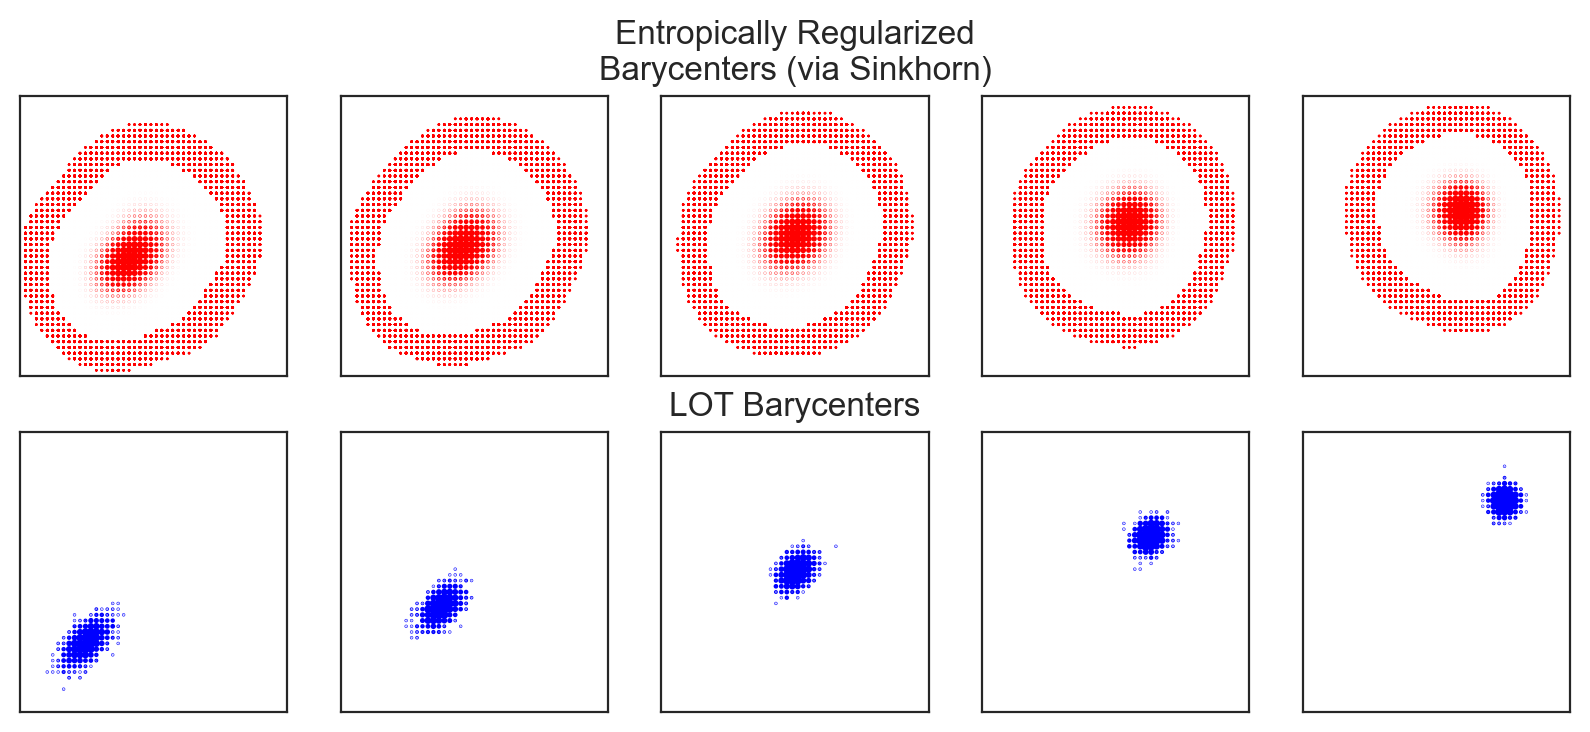

In [434]:
#Design stuff
sns.set_style("white")
plt.rcParams["figure.figsize"] = (10,4)
plt.rcParams["figure.dpi"] = 200

titleDict = {'fontsize': 12}

#Plot Grid with the template samples
fig, ax = plt.subplots(2,5)

for i in range(0,2):
    for j in range(0, 5):
        ax[i, j].set_xlim([-1.5, 1.5])
        ax[i, j].set_ylim([-1.5, 1.5])
        ax[i, j].set_xticks(num_gridPoints)
        ax[i, j].set_yticks(num_gridPoints)
        ax[i, j].xaxis.grid(False)
        ax[i, j].yaxis.grid(False)
        ax[i, j].tick_params(labelbottom=False)
        ax[i, j].tick_params(labelleft=False)

        if i==0:

            sinkhornBarycenter = ot.bregman.barycenter(np.asarray([template, sheared_template]).T, Cost, 3e-2, weights=[0.25 * j, 1 - 0.25*j])
            ax[i,j].scatter(grid_points[:,0],grid_points[:,1], s=1e2 * sinkhornBarycenter, c='red')

            if j == 2:
                ax[i,j].set_title('Entropically Regularized\nBarycenters (via Sinkhorn)', titleDict)

        if i==1:

            A1_hat, b1_hat = ot.da.OT_mapping_linear(reference_samples, unsheared_samples)
            A2_hat, b2_hat = ot.da.OT_mapping_linear(reference_samples, sheared_samples)

            # These are the LOT embeddings, so average them in L2 space.
            A_mid, b_mid = (0.25 * j) * A1_hat + (1 - 0.25*j) * A2_hat , (0.25 * j) * b1_hat + (1 - 0.25*j) * b2_hat

            # Now calculate the pushforward of the 1st template via the L2 midpoint map
            mu = np.matmul(A_mid, reference_mu) + b_mid
            cov = np.matmul(A_mid, np.matmul(reference_cov, np.transpose(A_mid)))

            pushforward_samples, pushforward_template = Gaussians.DiscreteGaussian(mu,cov,x,y,n,m)

            ax[i,j].scatter(grid_points[:,0],grid_points[:,1], s=1e2 * pushforward_template, c='blue')

            if j==2:
                ax[i,j].set_title('LOT Barycenters', titleDict)

#fig.savefig("Images/Geodesic.png",bbox_inches="tight",dpi=500)

In [435]:
#Build 4 rotated Gaussians and then build a Barycenter image grid

#Mean and covariance for template distribution

x = np.linspace(-2,2 - 1/n,n) #Grid step values on x-axis
y = np.linspace(-2,2 - 1/n,n) #Grid step values on y-axis

samples = []
templates = []
translations = [ [1,1], [-1, 1], [-1, -1], [1, -1]]
rotations = [225, 315, 45, 135]

learnedShears = []
learnedTranslations = []

for i in range(0,4):

    # Initializing plain mean and covariance
    mu = np.array([0,0])
    cov = pow(sigma,2)*np.identity(2)

    # Parameters for the shearing transform
    theta = np.radians(rotations[i])
    lambda_1 = 0.1
    lambda_2 = 0.3
    b = np.array(translations[i])

    # Create the shearing matrix
    P = np.asarray([[np.cos(theta), -np.sin(theta)],[np.sin(theta), np.cos(theta)]])
    Lambda = np.diag([lambda_1, lambda_2])
    A = np.matmul(np.transpose(P), np.matmul(Lambda,P))

    # Shear the mean and covariance matrices
    sheared_mu = np.matmul(A,mu) + b
    sheared_cov = np.matmul(A,np.transpose(A))
    s, t = Gaussians.DiscreteGaussian(sheared_mu,sheared_cov,x,y,n,m)
    samples.append(s)
    templates.append(t)

    centered_reference_samples, centered_reference_template = Gaussians.DiscreteGaussian(mu,cov,x,y,n,m)

    A, b = ot.da.OT_mapping_linear(centered_reference_samples, s)
    learnedShears.append(A)
    learnedTranslations.append(b)



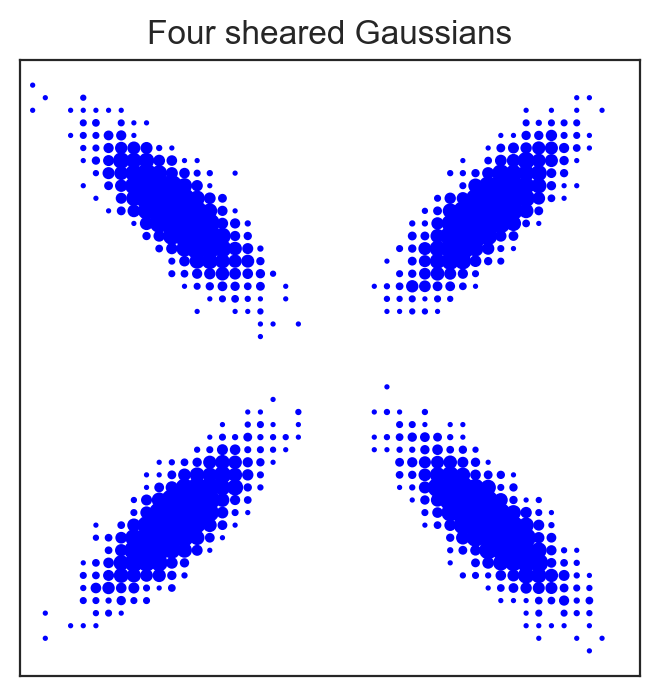

In [436]:
#Design stuff
sns.set_style("white")
plt.rcParams["figure.figsize"] = (4, 4)
plt.rcParams["figure.dpi"] = 200

fig, ax = plt.subplots(1,1)

titleDict = {'fontsize': 12}

ax.set_xlim([-1.5, 1.5])
ax.set_ylim([-1.5, 1.5])
ax.set_xticks(num_gridPoints)
ax.set_yticks(num_gridPoints)
ax.xaxis.grid(False)
ax.yaxis.grid(False)
ax.tick_params(labelbottom=False)
ax.tick_params(labelleft=False)

ax.set_title("Four sheared Gaussians")

for i in range(0,4):
    ax.scatter(grid_points[:,0],grid_points[:,1], s=2e3 * templates[i], c='blue')

#fig.savefig("Images/ExampleGaussians.png",bbox_inches="tight",dpi=500)

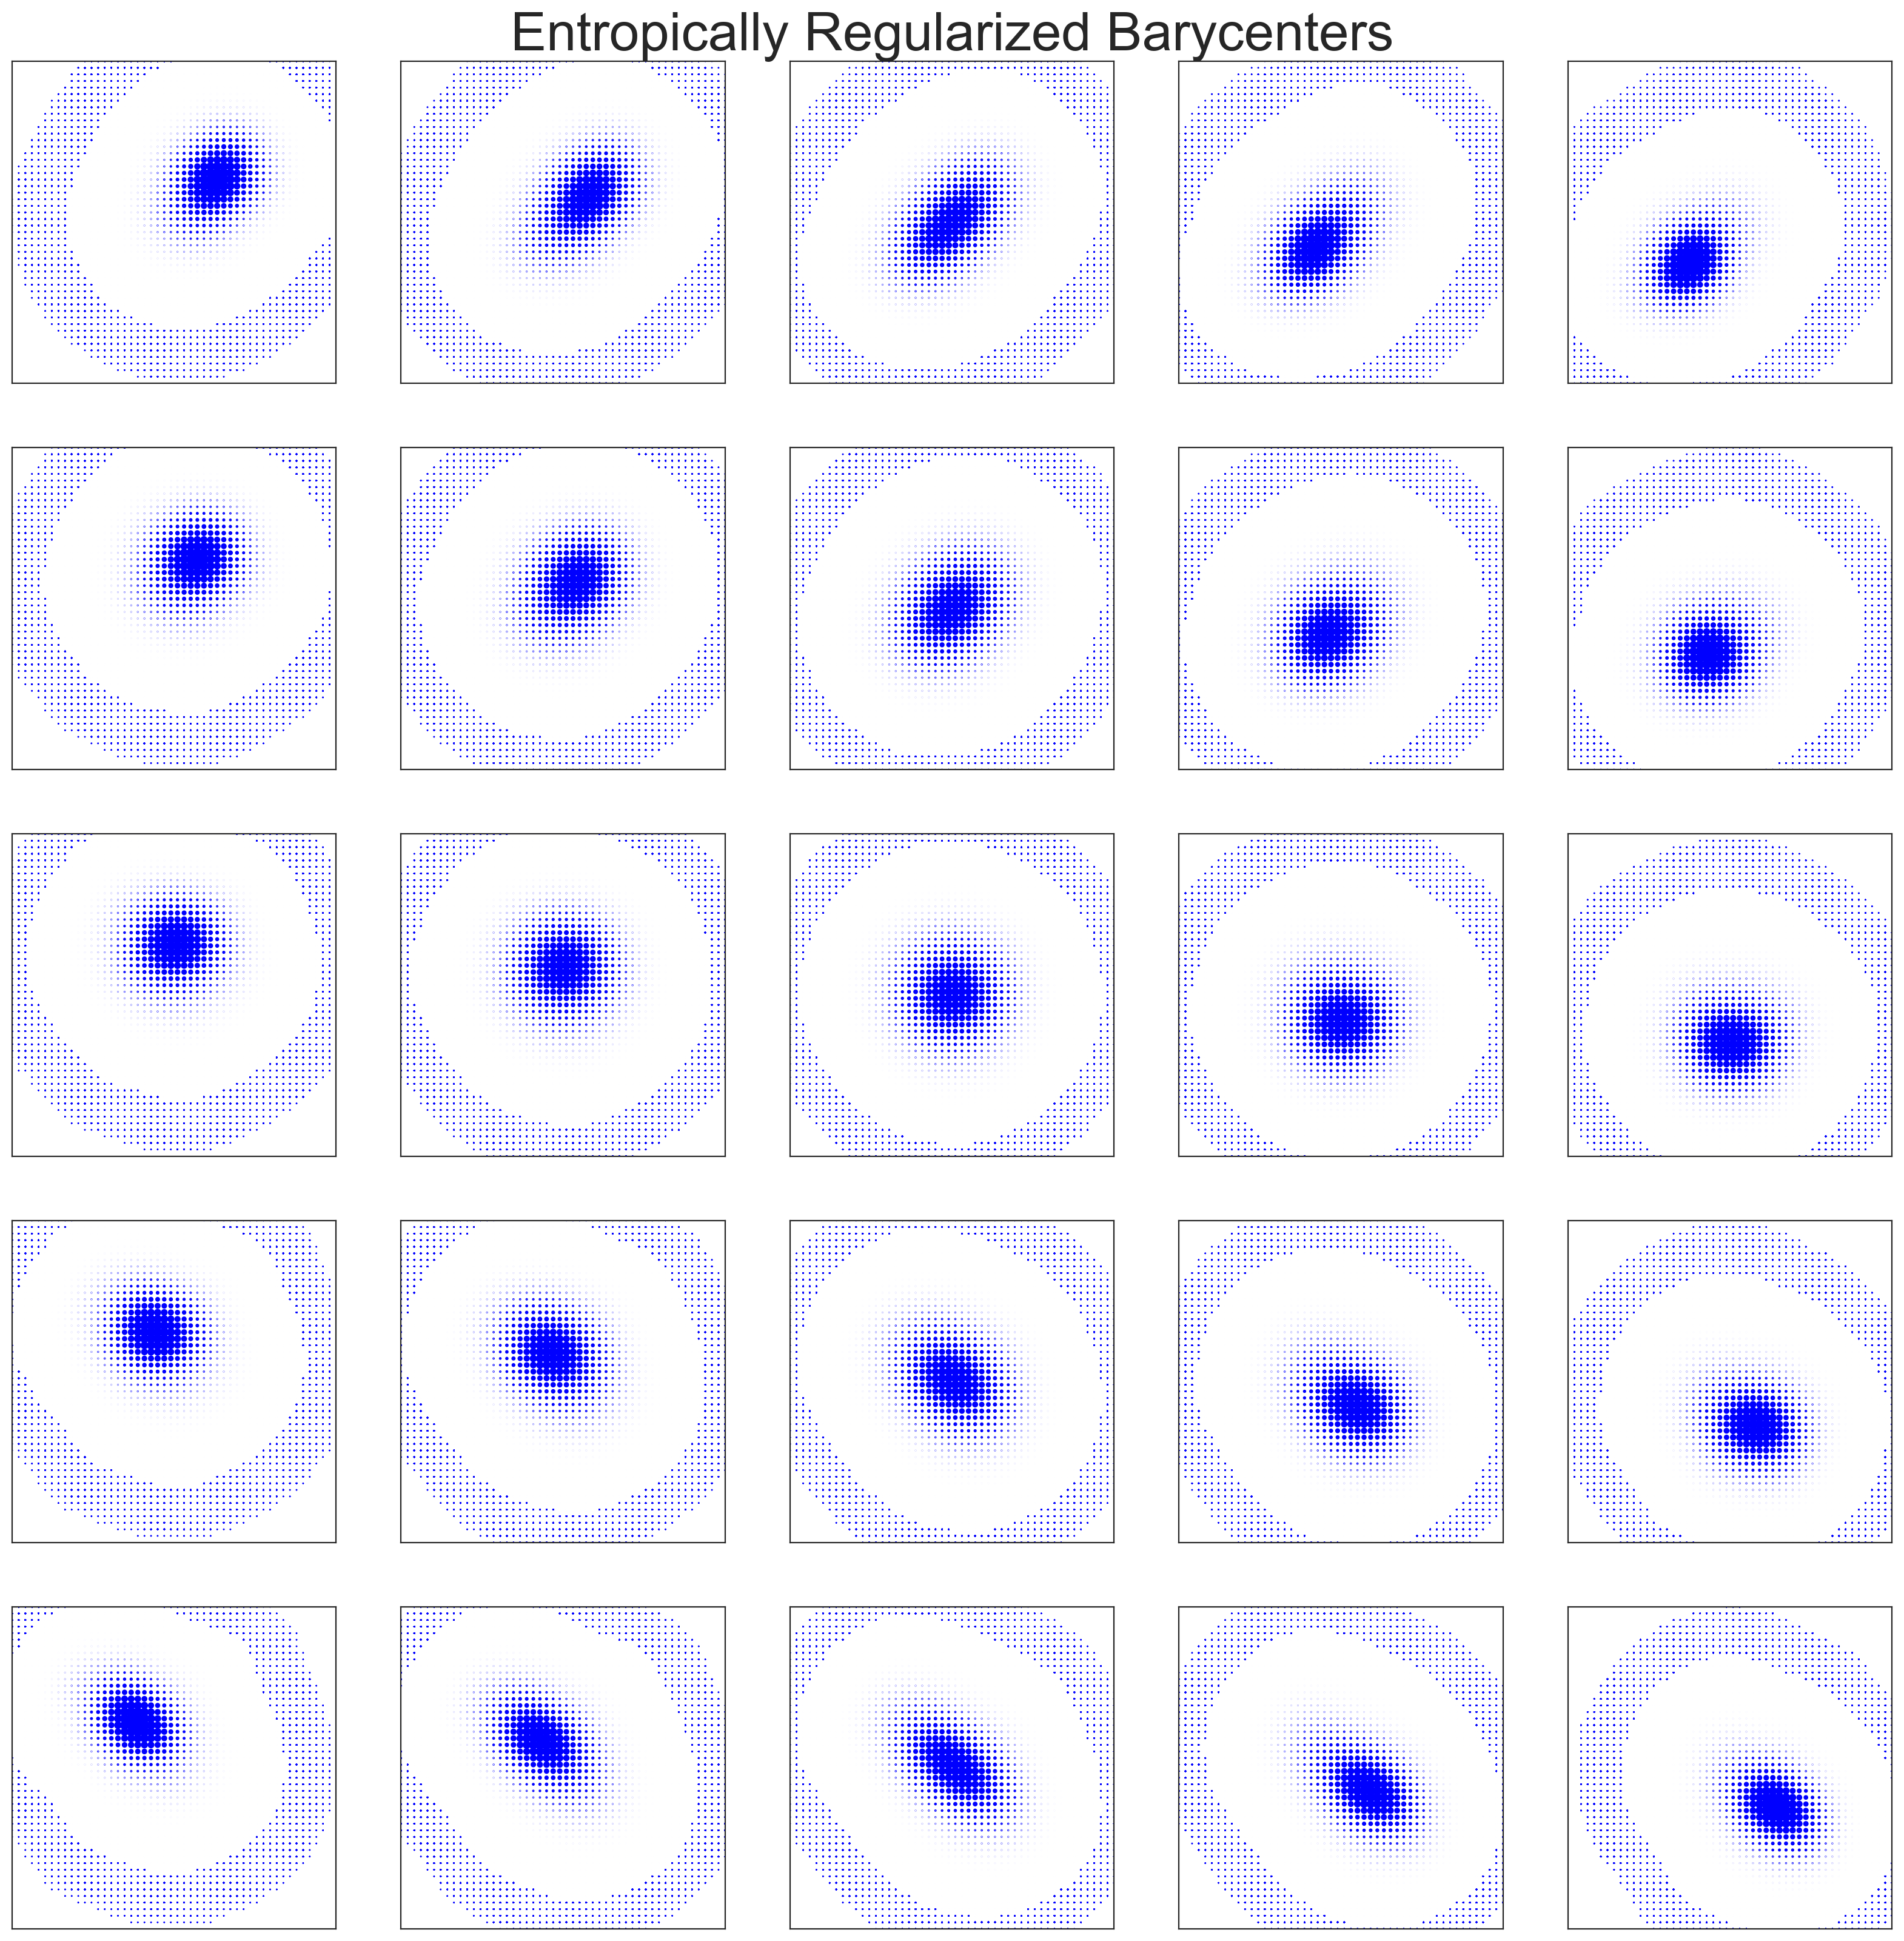

In [442]:
sns.set_style("white")
plt.rcParams["figure.figsize"] = (20, 20)
plt.rcParams["figure.dpi"] = 200

titleDict = {'fontsize': 32}

nb_images = 5
# those are the four corners coordinates that will be interpolated by bilinear
# interpolation
v1 = np.array((1, 0, 0, 0))
v2 = np.array((0, 1, 0, 0))
v3 = np.array((0, 0, 1, 0))
v4 = np.array((0, 0, 0, 1))

#Plot Grid with the template samples
fig, ax = plt.subplots(nb_images, nb_images)

for i in range(nb_images):
    for j in range(nb_images):
        tx = float(i) / (nb_images - 1)
        ty = float(j) / (nb_images - 1)

        # weights are constructed by bilinear interpolation
        tmp1 = (1 - tx) * v1 + tx * v2
        tmp2 = (1 - tx) * v3 + tx * v4
        w = (1 - ty) * tmp1 + ty * tmp2

        ax[i, j].set_xlim([-1.5, 1.5])
        ax[i, j].set_ylim([-1.5, 1.5])
        ax[i, j].set_xticks(num_gridPoints)
        ax[i, j].set_yticks(num_gridPoints)
        ax[i, j].xaxis.grid(False)
        ax[i, j].yaxis.grid(False)
        ax[i, j].tick_params(labelbottom=False)
        ax[i, j].tick_params(labelleft=False)

        sinkhornBarycenter = ot.bregman.barycenter(np.asarray(templates).T, Cost, 5e-2, weights=w)
        ax[i,j].scatter(grid_points[:,0],grid_points[:,1], s=1e3 * sinkhornBarycenter, c='blue')

ax[0,2].set_title("Entropically Regularized Barycenters", titleDict)
#fig.savefig("Images/SinkhornGrid.png",bbox_inches="tight",dpi=500)

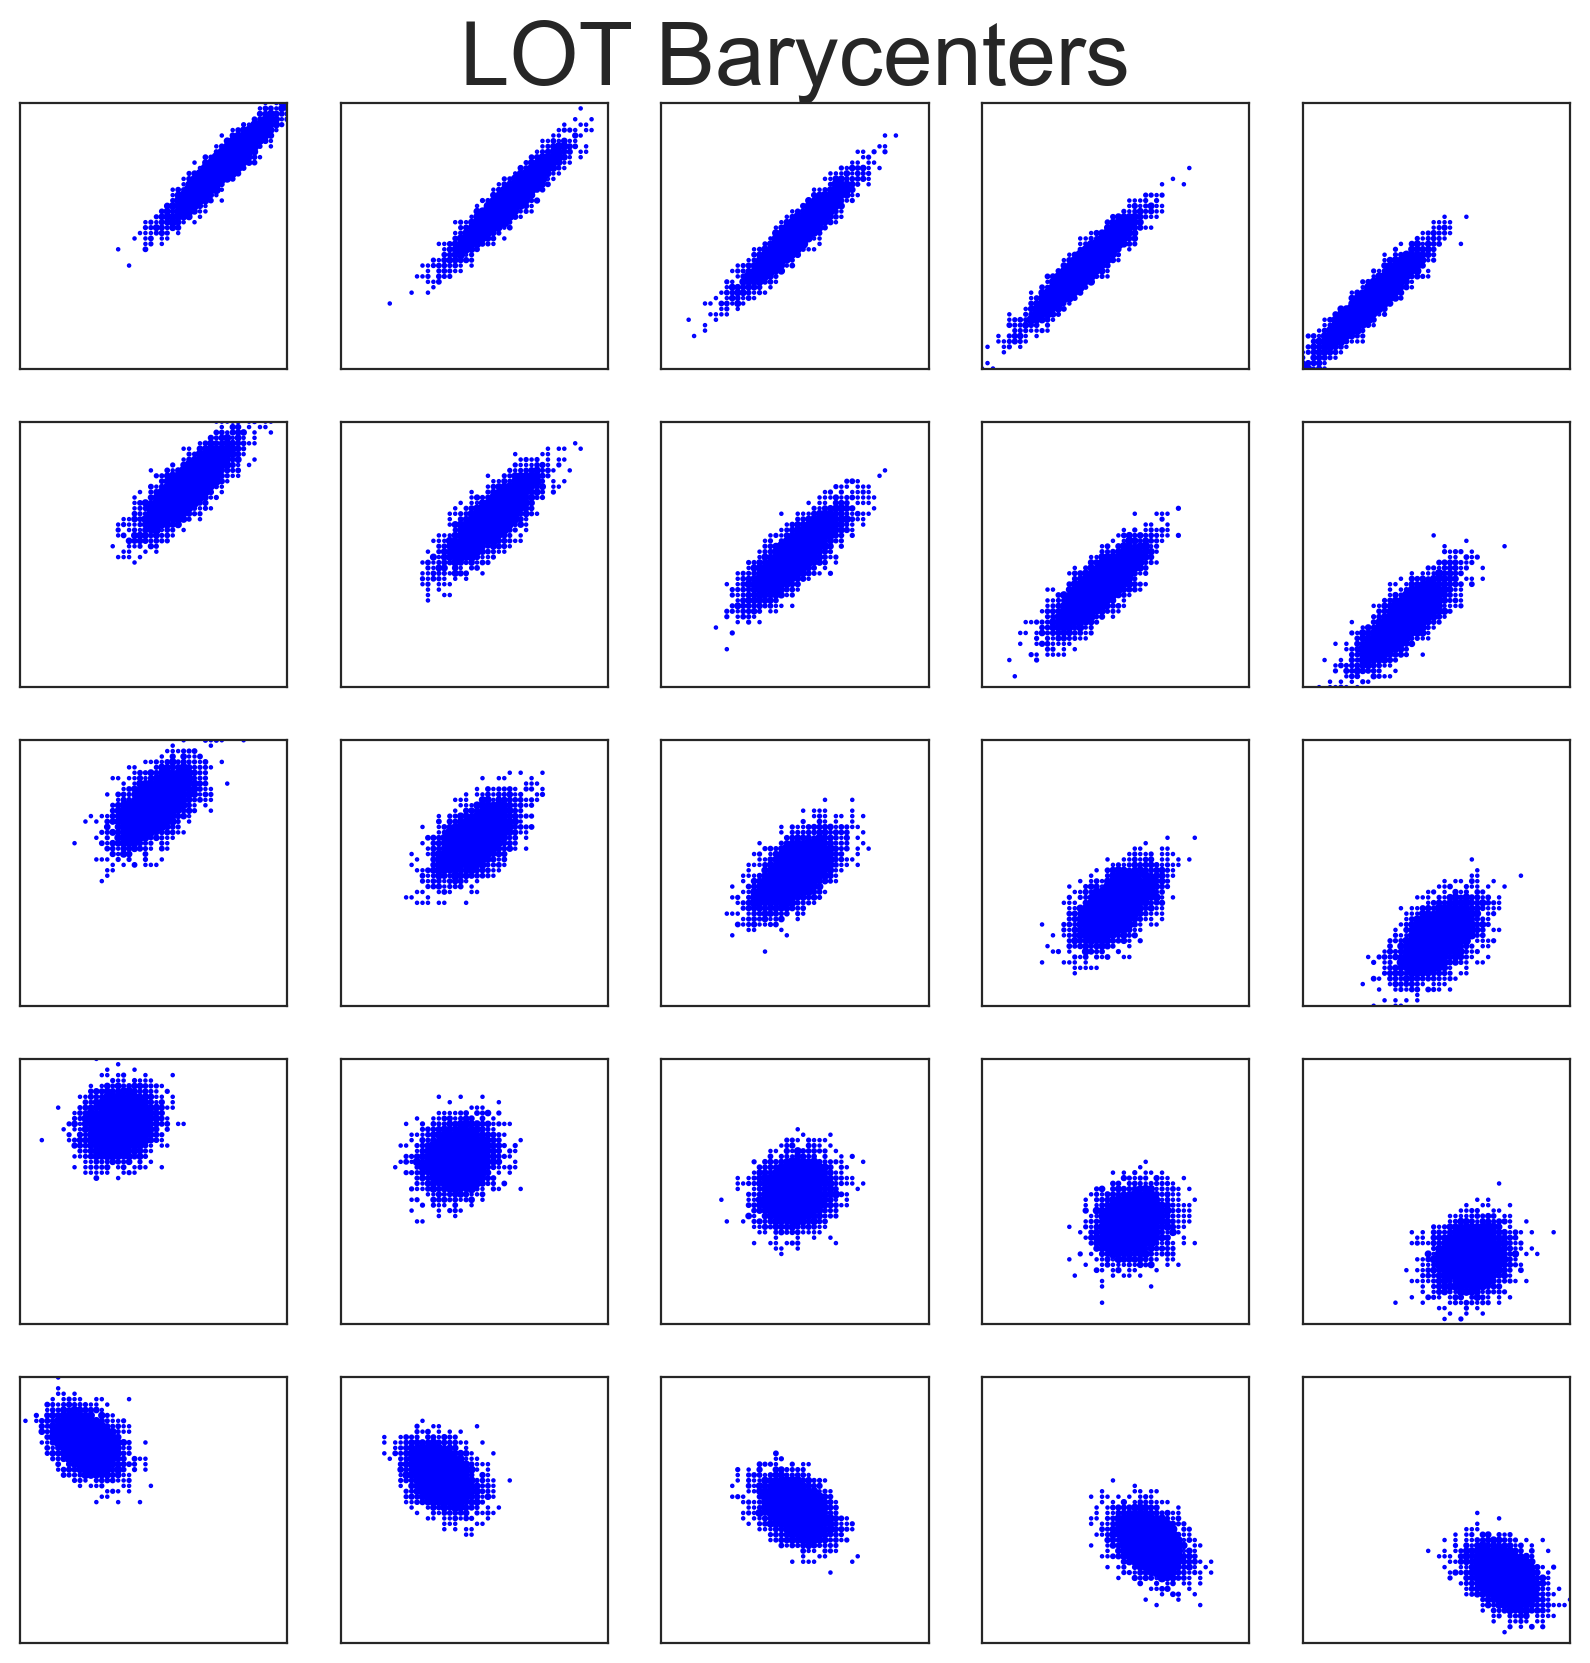

In [441]:
#Design stuff
sns.set_style("white")
plt.rcParams["figure.figsize"] = (10, 10)
plt.rcParams["figure.dpi"] = 200

titleDict = {'fontsize': 32}

nb_images = 5
# those are the four corners coordinates that will be interpolated by bilinear
# interpolation
v1 = np.array((1, 0, 0, 0))
v2 = np.array((0, 1, 0, 0))
v3 = np.array((0, 0, 1, 0))
v4 = np.array((0, 0, 0, 1))

#Plot Grid with the template samples
fig, ax = plt.subplots(nb_images, nb_images)

for i in range(nb_images):
    for j in range(nb_images):
        tx = float(i) / (nb_images - 1)
        ty = float(j) / (nb_images - 1)

        # weights are constructed by bilinear interpolation
        tmp1 = (1 - tx) * v1 + tx * v2
        tmp2 = (1 - tx) * v3 + tx * v4
        w = (1 - ty) * tmp1 + ty * tmp2

        ax[i, j].set_xlim([-1.5, 1.5])
        ax[i, j].set_ylim([-1.5, 1.5])
        ax[i, j].set_xticks(num_gridPoints)
        ax[i, j].set_yticks(num_gridPoints)
        ax[i, j].xaxis.grid(False)
        ax[i, j].yaxis.grid(False)
        ax[i, j].tick_params(labelbottom=False)
        ax[i, j].tick_params(labelleft=False)

        # These are the LOT embeddings, so average them in L2 space.
        A_mid, b_mid = np.array([[0,0], [0,0]]), np.array([0,0])
        for l in range(0,4):
            A_mid = A_mid + np.asarray(learnedShears[l] * w[l])
            b_mid = b_mid + np.asarray(learnedTranslations[l] * w[l])

        # Now calculate the pushforward of the 1st template via the L2 midpoint map
        mu = np.matmul(A_mid, reference_mu) + b_mid
        cov = np.matmul(A_mid, np.matmul(reference_cov, np.transpose(A_mid)))

        pushforward_samples, pushforward_template = Gaussians.DiscreteGaussian(mu,cov,x,y,n,m)

        ax[i,j].scatter(grid_points[:,0],grid_points[:,1], s=1e3 * pushforward_template, c='blue')

ax[0,2].set_title("LOT Barycenters", titleDict)
#fig.savefig("Images/LOTGrid.png",bbox_inches="tight",dpi=500)

In [379]:
np.asarray(learnedShears[2] * w[2])

array([[ 0., -0.],
       [-0.,  0.]])

In [374]:
np.matmul(w.T, learnedShears)

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 2 is different from 4)